In [1]:
# 加载必备库文件
import numpy as np

import mxnet as mx
from mxnet import nd
from mxnet import gluon
from mxnet import autograd

from mxnet.gluon import nn


In [2]:
# net.hybridize() 可以为继承 HybridBlock 类的层优化计算性能

def cbl_gen(channels, kernel_size, strides, padding):
    '''conv-BN-LeakyReLU cell'''
    cbl_unit = nn.HybridSequential()
    # 所有卷积后面都有 BN ，所以 bias 始终为 False
    cbl_unit.add(
        nn.Conv2D(channels, kernel_size=kernel_size, strides=strides, padding=padding, groups=1, use_bias=False),
        nn.BatchNorm(),
        nn.LeakyReLU(0.1)
    )
    
    return cbl_unit


# 残差网络需要重新定义前向传播的方式，必须自己定义网络层类
class DarknetBasicBlockV3(gluon.HybridBlock):
    '''darknetV3 basic block'''
    
    def __init__(self, channels, **kwargs):        
        super(DarknetBasicBlockV3, self).__init__(**kwargs)        
        self.body = nn.HybridSequential()
        self.body.add(
            # 1x1 conv; 看 darknet 中 yolov3.cfg 文件中 1x1 卷积的 padding 也是 1 ？？？ gluoncv 中并没有
            cbl_gen(channels, (1,1), (1,1), (0,0)),
            # 3x3 conv
            cbl_gen(channels*2, (3,3), (1,1), (1,1))
        )
    # 需要在 hybrid_forward 函数中添加额外的输入F。由于 MXNet 既有基于命令式编程的 NDArray 类，
    # 又有基于符号式编程的 Symbol 类。由于这两个类的函数基本一致，MXNet会根据输入来决定 F 使用 NDArray 或 Symbol。    
    def hybrid_forward(self, F, x):
        return x + self.body(x)

        
class Darknet53(gluon.HybridBlock):
    '''darknet53'''
    
    def __init__(self, residual_block_num, channels, class_num=1000, **kwargs):
        super(Darknet53, self).__init__(**kwargs)
        self.features = nn.HybridSequential()
        
        # 网络最开始有一个卷积操作
        self.features.add(cbl_gen(channels[0], (3,3), (1,1), (1,1)))
        
        # 重复的残差块
        for residual_block, channel in zip(residual_block_num, channels[1]):
            # 使用步长为 2 的卷积实现下采样，在每一个残差块的开始都有一个下采样层
            self.features.add(cbl_gen(channel*2, (3,3), (2,2), (1,1)))
            # 一个残差块
            for _ in range(residual_block):
                self.features.add(DarknetBasicBlockV3(channel))
        
        # global average pooling
        self.pooling = nn.GlobalAvgPool2D()
        
        # 全连接的输出层
        self.output = nn.Dense(class_num)
        
    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.pooling(x)
        return self.output(x)

    

# default configurations
residual_block_num = [1, 2, 8, 8, 4] # 残差块的个数
darknet_channels = [32, [32, 64, 128, 256, 512]] # 对应残差块 1x1 卷积输出 channel 个数，3x3 卷积输出 channel 个数翻倍
class_num_imagenet = 1000 # for imagenet

In [3]:

class Concates(gluon.HybridBlock):
    """不同 stage 的 feature maps 串接的时候，先经过了一个 1x1 卷积和一个上采样
    """
    def __init__(self, channels, **kwargs):
        super(Concates, self).__init__(*kwargs)
        self.concate = nn.HybridSequential(prefix='')
        self.concate.add(cbl_gen(channels, (1,1), (1,1), (0,0)))
        
    def upsample_rept(self, x, stride):
        '''
        不同的检测层输入堆叠的时候需要上采样，上采样的方式也很简单，
        只是将 feature maps 沿着水平和垂直方向 repeat 指定的倍数。
        >>> a
        array([[0, 1],
               [2, 3]])
        >>> a.repeat(axis=-1,repeats=1)
        array([[0, 1],
               [2, 3]])
        >>> a.repeat(axis=-1,repeats=2)
        array([[0, 0, 1, 1],
               [2, 2, 3, 3]])
        >>> a.repeat(axis=-1,repeats=2).repeat(axis=-2,repeats=2)
        array([[0, 0, 1, 1],
               [0, 0, 1, 1],
               [2, 2, 3, 3],
               [2, 2, 3, 3]])

        '''
        assert type(x) == mx.ndarray.ndarray.NDArray or type(x) == np.ndarray
        return x.repeat(axis=-1, repeats=stride).repeat(axis=-2, repeats=stride)    
    
    def hybrid_forward(self, F, x):
        x = self.concate(x)
        x = self.upsample_rept(x, 2)
        return x

    
class Detection(gluon.HybridBlock):
    '''
    检测网络，三个检测网络的结构相同，只是 filter 个数不同,
    完全可以使用一个 for 循环实现，
    但是需要在倒数第二层引出分支，和前面层的特征合并后，用于前面的检测网络，所以只能分开写

    越靠近输入层， feature maps 越大，所以检测网络使用的 channel 相应的较少，防止较大运算量
    '''
    def __init__(self, channels, classes_num=80, anchors_num=3, **kwargs):
        super(Detection, self).__init__(**kwargs)
        self.channels=channels
        self.anchors_num=anchors_num
        self.pred_num=1+4+classes_num
        self.body=nn.HybridSequential(prefix='')
        self.tip=nn.HybridSequential(prefix='')

        for i in range(2):
            self.body.add(cbl_gen(channels, (1,1), (1,1), (0,0)))
            self.body.add(cbl_gen(channels*2, (3,3), (1,1), (1,1)))
            
        self.body.add(cbl_gen(channels, (1,1), (1,1), (0,0)))        
        self.tip.add(cbl_gen(channels*2, (3,3), (1,1), (1,1)))        

        
    def hybrid_forward(self, F, x):
        x = self.body(x)
        return self.tip(x)


class Output(gluon.HybridBlock):
    """YOLOv3 输出
    """
    def __init__(self, anchors, stride, classes_num=80, **kwargs):
        super(Output, self).__init__(**kwargs)
        self.stride = stride
        self.anchors_num = len(anchors) // 2
        self.classes_num = classes_num
        self.pred_num = 1+4+classes_num
        anchors = nd.array(anchors).astype('float32')
        self.anchors = anchors.reshape(1, 1, -1, 2)

        self.output = nn.HybridSequential(prefix='')
        # 这里是线性激活函数，默认 nn.Conv2D 的 activation=None，两者等效
        # 输出 channel 的个数 (4+1+classes)*anchors
        self.output.add(nn.Conv2D(self.pred_num*self.anchors_num, (1,1), (1,1), (0,0), groups=1, use_bias=True))        

        # offsets will be added to predictions
        grid_x = np.arange(128)
        grid_y = np.arange(128)
        grid_x, grid_y = np.meshgrid(grid_x, grid_y)
        # stack to (n, n, 2)
        offsets = np.concatenate((grid_x[:, :, np.newaxis], grid_y[:, :, np.newaxis]), axis=-1)
        # expand dims to (1, 1, n, n, 2) so it's easier for broadcasting
        offsets = np.expand_dims(np.expand_dims(offsets, axis=0), axis=0)
        self.offsets = nd.array(offsets)#self.params.get_constant('offset_%d'%(index), offsets)
        
        
    def hybrid_forward(self, F, x):
        pred = self.output(x)

        # prediction flat to (batch, pred per pixel, height * width)
        pred = pred.reshape((0, self.anchors_num * self.pred_num, -1))
        # transpose to (batch, height * width, num_anchor, num_pred)
        pred = pred.transpose(axes=(0, 2, 1)).reshape((0, -1, self.anchors_num, self.pred_num))
        # components
        raw_box_centers = pred.slice_axis(axis=-1, begin=0, end=2)
        raw_box_scales = pred.slice_axis(axis=-1, begin=2, end=4)
        objness = pred.slice_axis(axis=-1, begin=4, end=5)
        class_pred = pred.slice_axis(axis=-1, begin=5, end=None)

        # valid offsets, (1, 1, height, width, 2)
        offsets = nd.slice_like(self.offsets, x * 0, axes=(2, 3))
        # reshape to (1, height*width, 1, 2)
        offsets = offsets.reshape((1, -1, 1, 2))

        box_centers = nd.broadcast_add(nd.sigmoid(raw_box_centers), offsets) * self.stride
        box_scales = nd.broadcast_mul(nd.exp(raw_box_scales), self.anchors)
        confidence = nd.sigmoid(objness)
        class_score = nd.broadcast_mul(nd.sigmoid(class_pred), confidence)
        wh = box_scales / 2.0
        # `corner`: [xmin, ymin, xmax, ymax]
        # `center`: [x, y, width, height]
        # center to corner
        bbox = nd.concat(box_centers - wh, box_centers + wh, dim=-1)

        if autograd.is_training():
            # during training, we don't need to convert whole bunch of info to detection results
            return (bbox.reshape((0, -1, 4)), raw_box_centers, raw_box_scales,
                    objness, class_pred, self.anchors, offsets)

        # prediction per class
        bboxes = nd.tile(bbox, reps=(self.classes_num, 1, 1, 1, 1))
        scores = nd.transpose(class_score, axes=(3, 0, 1, 2)).expand_dims(axis=-1)
        ids = nd.broadcast_add(scores * 0, F.arange(0, self.classes_num).reshape((0, 1, 1, 1, 1)))
        detections = nd.concat(ids, scores, bboxes, dim=-1)
        # reshape to (B, xx, 6)
        detections = nd.reshape(detections.transpose(axes=(1, 0, 2, 3, 4)), (0, -1, 6))
        return detections


# 三个输出分别使用的检测通道数
det_channels = [512, 256, 128]

# 这里都进行了反序
strides = [32, 16, 8]
anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]    

In [4]:
class YOLOv3(gluon.HybridBlock):
    """生成 YOLOv3 网络，只适用于 Darknet53 ，
    """
    def __init__(self, **kwargs):
        super(YOLOv3, self).__init__(**kwargs)

        # 基本网络框架
        darknet53 = Darknet53(residual_block_num, darknet_channels)
        # residual_block_num = [1, 2, 8, 8, 4] , 每一个残差块的开始都有一个下采样层
        feature1_layer = 1 + (1+1) + (1+2) + (1+8)
        feature2_layer = feature1_layer + (1+8)
        feature3_layer = feature2_layer + (1+4) # 可以直接到末尾，

        self.features = nn.HybridSequential(prefix='')
        self.features.add(darknet53.features[:feature1_layer])
        self.features.add(darknet53.features[feature1_layer:feature2_layer])
        self.features.add(darknet53.features[feature2_layer:feature3_layer])

        # 从基本网络框架引出的检测网络层，包含输出
        self.detection_net = nn.HybridSequential(prefix='')
        for det_channel in det_channels:
            self.detection_net.add(Detection(det_channel))

        # 串接不同 stage 
        self.concates = nn.HybridSequential(prefix='')
        for det_channel in det_channels[1:]:
            self.concates.add(Concates(det_channel))
 
        # 输出
        self.output = nn.HybridSequential(prefix='')
        for anchor, stride in zip(anchors, strides):
            self.output.add(Output(anchor, stride))


    def hybrid_forward(self, F, x):

        # 先计算出所有 stage 的 features
        featuremaps = []
        for net in self.features:
            x = net(x)
            featuremaps.append(x)

        # 反序
        featuremaps = featuremaps[::-1]

        output = []
        det = nd.array([])
        for i in range(len(featuremaps)):
            if i == 0:
                det = featuremaps[i]
            else:
                det = self.concates[i-1](det)
                det = nd.concat(det, featuremaps[i], dim=1)

            det = self.detection_net[i].body(det)   
            out = self.detection_net[i].tip(det)
            out = self.output[i](out)
            output.append(out)

        return output


In [5]:
# coco 80 个类
classes_name = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
                'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
                'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
                'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
                'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [6]:
# 保存 gluoncv 训练好的参数
from gluoncv import model_zoo

model_net = model_zoo.get_model('yolo3_darknet53_coco', pretrained=True)

# 打印参数
# print(net.stages[0][0][0].params['darknetv30_conv0_weight'].data())

# 保存网络的参数
# DarkNet 提取特征层
model_net.stages.save_parameters("features.params")

# 检测网络
for i in range(3):
    name = "body_%d.params" % (i)
    model_net.yolo_blocks[i].body.save_parameters(name)
    name = "tip_%d.params" % (i)
    model_net.yolo_blocks[i].tip.save_parameters(name)

# 不同检测网络链接的转换层
for i in range(2):
    name = "concate_%d.params" % (i)
    model_net.transitions[i].save_parameters(name)

# 输出层
for i in range(3):
    name = "outputs_%d.params" % (i)
    model_net.yolo_outputs[i].prediction.save_parameters(name)

In [7]:
# 加载参数
net = YOLOv3()

net.features.load_parameters('features.params')

# 由于和 gluoncv 的网络结构不同（自己的网络 tip 外面有两层 HybridSequential ），只能分开加载
for i in range(3):
    name = "body_%d.params" % (i)
    net.detection_net[i].body.load_parameters(name)
    name = "tip_%d.params" % (i)
    net.detection_net[i].tip[0].load_parameters(name)

for i in range(2):
    name = "concate_%d.params" % (i)
    net.concates[i].concate[0].load_parameters(name)

for i in range(3):
    name = "outputs_%d.params" % (i)
    net.output[i].output[0].load_parameters(name)

In [ ]:
#net.hybridize()
#net.export("v3-self")

In [8]:
def preprocessing_img(imgname, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """图像 nominalize 
    测试的时候，transform 不需要额外的处理，只需要归一化以及将 BCWH -> 

    Parameters
    ----------
    imgs : string 
        待处理的图像名字
    mean : iterable of float
        Mean pixel values.
    std : iterable of float
        Standard deviations of pixel values.

    Returns
    -------
    网络的输入和 resize 后的图像

    """

    img = mx.image.imread(imgname)

    # 只能在 416*416 时 work
    img = mx.image.imresize(img, 416, 416)
    orig_img = img.asnumpy().astype('uint8')
    img = mx.nd.image.to_tensor(img)
    img = mx.nd.image.normalize(img, mean=mean, std=std)
    # img.expand_dims(0) 由 CHW -> BCHW
    return img.expand_dims(0), orig_img

In [9]:
imgname = 'giraffe.jpg'
imgname = 'person.jpg'
imgname = 'horses.jpg'
imgname = 'kite.jpg'
imgname = 'Machine-Learning.png'
imgname = 'scream.jpg'
imgname = '2012112309354235343.jpg'
imgname = '2014080709271034505~04.jpg'
imgname = 'eagle.jpg'
imgname = 'dog.jpg'
#imgname = '2014080815450057297.jpg'
x, img = preprocessing_img(imgname)

In [10]:
y = net(x)

In [11]:
maxoutput = 100
class_threshold = 0.5

def clean_output(data, maxoutput, class_threshold):
    """找到最大输出个数的值，并删掉低概率的值
    data: Ndarray
        待处理数据 
    maxoutput: int
        最大输出个数
    class_thread: float
        类别概率阈值，低于该值的不予输出
    """
    output = nd.array([[0,0,0,0,0,0]])

    # 先从每个输出中取出最大个数的输出，并拼接
    for i in range(len(data)):
        # 压缩维度，自动去掉值为 1 的维度
        res = np.squeeze(data[i])

        index = res[:,1].argsort()
        index = index[::-1][:maxoutput]
        otmp = res[index,:]

        output = nd.concat(output,otmp,dim=0)

    output = output.asnumpy()
    keepindex = np.where(output[:,1] >= class_threshold)[0]
    output = output[keepindex,:]
    if len(output) > maxoutput:
        index = output[:,1].argsort()
        index = index[::-1][:maxoutput]
        output = output[index,:]
    return output

# bbox 是 (xmin,ymin,xmax,ymax) 格式
output = clean_output(y, maxoutput, class_threshold)

In [ ]:
print(output)

In [12]:
def  classify_ouput(data):
    """将输出分类，便于分类别进行 NMS
    data : numpy array

    输出 list 
    """
    # 按照类别进行排序
    index = data[:,0].argsort()
    data = data[index,:]

    split_index = []
    clas = data[0,0]
    index = 0
    for i in range(1, len(data)):
        index += 1
        if clas != data[i,0]:
            split_index.append(index)
            clas = data[i,0]    

    return np.split(data, split_index)


classoutput = classify_ouput(output)

In [13]:
def compute_iou(bbox_a, bbox_b):
    """计算两组 bounding boxes 的 Intersection-Over-Union(IOU)

    Parameters
    ----------
    bbox_a : numpy.ndarray
        shape (M, 4) . bbox 格式 (xmin,ymin,xmax,ymax)
    bbox_b : numpy.ndarray
        shape (N, 4) . bbox 格式 (xmin,ymin,xmax,ymax)

    Returns
    -------
    二维数组 shape (M,N) ，其中任意一个元素 (i,j) 表示 bboxa[i] 和 bboxb[j] 的 IoU

    """

    if bbox_a.shape[1] < 4 or bbox_b.shape[1] < 4:
        raise IndexError("Bounding boxes axis 1 must have at least length 4")

    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    br = np.minimum(bbox_a[:, None, 2:4], bbox_b[:, 2:4])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:4] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:4] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)


# 依据 score 排序，从 score 最高第一个 box 开始，所有与该 box IOU 大于指定阈值的
# box 都会被删掉；同时把 box 加入到最终的队列中，并从原 list 中删除。
# 接着用队列中剩下的 score 最高的 box 去抑制队列中剩余的 box

# 可以先删掉 score 比较低的 box
def non_max_suppression(boxes, scores, threshold=0.7):
    """Performs non-maximum suppression and returns indices of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering. 一般为 0.7
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    # scores 从大到小排序
    ixs = scores.argsort()[::-1]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        # 每次都选择队列中 score 最高的 box ，并用他抑制队列中剩余的 box
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i][np.newaxis,:], boxes[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[1] + 1
        # Remove indices of the picked and overlapped boxes.
        # 所有与 score 最高的 box IoU 大于阈值的 box 都从队列中移除
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    return np.array(pick, dtype=np.int32)


In [14]:
def classnms(data, threshold=0.7):
    """将输出结果分类别进行 NMS ，输出处理后的结果"""

    output = []
    for i in range(len(data)):
        bbox = data[i][:,2:]
        score = data[i][:,1]
        keepindex = non_max_suppression(bbox, score, threshold)
        if i == 0:
            output = data[i][keepindex,:]
        else:
            output = np.row_stack([output,data[i][keepindex,:]])

    return output

plotoutput = classnms(classoutput)

In [ ]:
print(plotoutput)

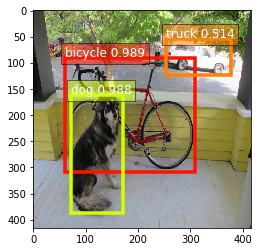

In [15]:
from gluoncv import utils
from matplotlib import pyplot as plt
%matplotlib inline

bounding_boxs = plotoutput[:,2:]
scores = plotoutput[:,1]
class_IDs = plotoutput[:,0]
ax = utils.viz.plot_bbox(img, bounding_boxs, scores,
                         class_IDs, class_names=classes_name)
plt.show()